# In this notebook, we are going to implement CNN model to analysis the data
# Applied oversampling for the imbalance data.
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [73]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image



In [74]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [75]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id     dx    dx_type   age     sex  \
24    HAM_0004884  ISIC_0025937    bkl      histo  75.0    male   
9867  HAM_0000688  ISIC_0026720  akiec      histo  75.0    male   
3611  HAM_0000657  ISIC_0030955     nv  follow_up  45.0    male   
4692  HAM_0000469  ISIC_0025408     nv  follow_up  50.0  female   
580   HAM_0002350  ISIC_0026290    bkl      histo  85.0    male   

         localization  label  
24    upper extremity      2  
9867  lower extremity      0  
3611          abdomen      5  
4692          abdomen      5  
580   lower extremity      2  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [76]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [77]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [78]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

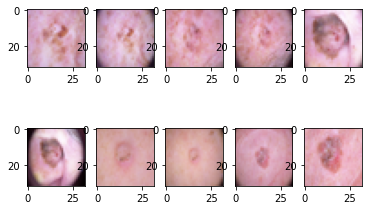

In [79]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [96]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)

In [97]:
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)

In [98]:
# apply oversampling instead of class weight
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=87)
train_data = train_data.reshape(-1,image_size*image_size*3)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(-1,image_size,image_size,3)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [99]:
#setup CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#CNN layer 1:
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#Flatten layer
model.add(Flatten())
model.add(Dropout(0.4))

#hidden layer 1
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.4))

#hidden layer 2
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.4))


#output layer
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_56 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_57 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 16, 16, 64)      

In [100]:
# Train
batch_size = 256
epochs = 10

train_history = model.fit(
    train_data_oversample,train_label_oversample,
    epochs=epochs,
    batch_size= batch_size,
    validation_split=0.2,
    verbose=2,shuffle=True)

model.save_weights('CNN_V2.h5')

Epoch 1/10
118/118 - 47s - loss: 1.6277 - acc: 0.2803 - val_loss: 3.8982 - val_acc: 0.0000e+00
Epoch 2/10
118/118 - 46s - loss: 1.4102 - acc: 0.3915 - val_loss: 3.8233 - val_acc: 0.2113
Epoch 3/10
118/118 - 45s - loss: 1.1677 - acc: 0.5365 - val_loss: 3.1920 - val_acc: 0.1417
Epoch 4/10
118/118 - 45s - loss: 0.8824 - acc: 0.6670 - val_loss: 2.4547 - val_acc: 0.2232
Epoch 5/10
118/118 - 45s - loss: 0.6717 - acc: 0.7485 - val_loss: 2.5739 - val_acc: 0.3344
Epoch 6/10
118/118 - 45s - loss: 0.5443 - acc: 0.7974 - val_loss: 1.2855 - val_acc: 0.5936
Epoch 7/10
118/118 - 44s - loss: 0.4571 - acc: 0.8282 - val_loss: 1.1465 - val_acc: 0.7153
Epoch 8/10
118/118 - 44s - loss: 0.3758 - acc: 0.8588 - val_loss: 1.0915 - val_acc: 0.6931
Epoch 9/10
118/118 - 44s - loss: 0.3282 - acc: 0.8774 - val_loss: 0.8816 - val_acc: 0.7402
Epoch 10/10
118/118 - 44s - loss: 0.2952 - acc: 0.8883 - val_loss: 0.8308 - val_acc: 0.7537


In [101]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

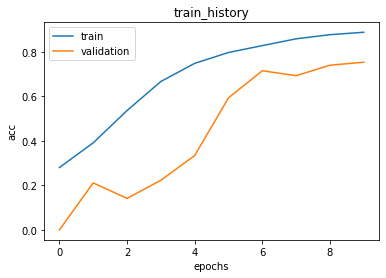

In [102]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

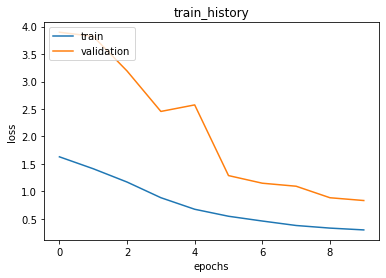

In [103]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [106]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 14ms/step - loss: 1.0763 - acc: 0.6186

In [107]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))


[2 5 4 ... 5 2 1]
predict   0   1    2  3    4    5   6
label                                
0        23  12   13  3   12    2   0
1        10  52   24  3    8    5   1
2         5  13  154  1   35   12   0
3         3   9    3  7    0    1   0
4         3   4   59  0  130   26   1
5         8  33  222  2  216  857   3
6         0   2    3  0    3    4  16
predicted  akiex  bcc  bkl  df  mel   nv  vasc
actual                                        
akiex         23   12   13   3   12    2     0
bcc           10   52   24   3    8    5     1
bkl            5   13  154   1   35   12     0
df             3    9    3   7    0    1     0
mel            3    4   59   0  130   26     1
nv             8   33  222   2  216  857     3
vasc           0    2    3   0    3    4    16
